In [33]:
import os
import pandas as pd
from glob import glob
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import cv2
import random
import seaborn as sns
import tensorflow as tf
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, precision_recall_curve
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers, regularizers
from transformers import ViTFeatureExtractor, ViTForImageClassification
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image

In [34]:
# Dataset paths
base_path = "dataset"

# folder names
folders = ["train", "test"]

# Initialize list to store image paths and labels
image_data = []
images = []

for folder in folders:
    for category in ["real", "fake"]:
        category_path = os.path.join(base_path, folder, category)
        image_files = glob(os.path.join(category_path, "*")) 
        for img in image_files:
            image_data.append((img, category))
            img_pil = np.array(Image.open(img).convert('RGB'))
            images.append(img_pil)


# Convert to DataFrame
df = pd.DataFrame(image_data, columns=["image_path", "label"])



/Users/adaeze/anaconda3/envs/pr_ai/lib/python3.12/site-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


In [35]:
df['image_vector'] = images

In [36]:
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

In [37]:


# Get image dimensions and formats
resolutions = []
formats = []
file_sizes = []

# Sample a few images from each category
for category in ['train/real', 'train/fake', 'test/real', 'test/fake']:
    path = os.path.join('dataset', category)
    if os.path.exists(path):
        files = os.listdir(path)[:20]  # Sample first 20 images
        for file in files:
            img_path = os.path.join(path, file)
            try:
                img = Image.open(img_path)
                resolutions.append(img.size)
                formats.append(img.format)
                file_sizes.append(os.path.getsize(img_path) / 1024)  # KB
            except Exception as e:
                print(f"Error with {img_path}: {e}")

# Analyze dimensions
unique_resolutions = set(resolutions)
print(f"Number of unique resolutions: {len(unique_resolutions)}")
print(f"Most common resolutions: {sorted(unique_resolutions)[:5]}")

# Analyze formats
unique_formats = set(formats)
print(f"Image formats: {unique_formats}")

# Analyze file sizes
avg_size = np.mean(file_sizes)
min_size = np.min(file_sizes)
max_size = np.max(file_sizes)
print(f"File sizes - Avg: {avg_size:.2f}KB, Min: {min_size:.2f}KB, Max: {max_size:.2f}KB")
print(df.head())
num_images = df.shape[0]
print(f"Total images: {num_images}")

Number of unique resolutions: 72
Most common resolutions: [(189, 267), (236, 300), (275, 183), (294, 171), (300, 168)]
Image formats: {'JPEG', 'PNG'}
File sizes - Avg: 501.25KB, Min: 11.55KB, Max: 3772.35KB
                    image_path label  \
0  dataset/train/real/5360.jpg  real   
1   dataset/test/real/5000.jpg  real   
2  dataset/train/real/5387.jpg  real   
3     dataset/test/fake/78.jpg  fake   
4  dataset/train/real/5284.jpg  real   

                                        image_vector  
0  [[[219, 200, 160], [205, 186, 146], [210, 190,...  
1  [[[78, 90, 44], [78, 90, 44], [78, 90, 44], [7...  
2  [[[246, 244, 245], [246, 244, 245], [246, 244,...  
3  [[[23, 91, 126], [23, 91, 126], [24, 92, 127],...  
4  [[[106, 164, 210], [106, 164, 210], [105, 163,...  
Total images: 978


In [38]:
df.head()

,image_path,label,image_vector
0,dataset/train/real/5360.jpg,real,"[[[219, 200, 160], [205, 186, 146], [210, 190,..."
1,dataset/test/real/5000.jpg,real,"[[[78, 90, 44], [78, 90, 44], [78, 90, 44], [7..."
2,dataset/train/real/5387.jpg,real,"[[[246, 244, 245], [246, 244, 245], [246, 244,..."
3,dataset/test/fake/78.jpg,fake,"[[[23, 91, 126], [23, 91, 126], [24, 92, 127],..."
4,dataset/train/real/5284.jpg,real,"[[[106, 164, 210], [106, 164, 210], [105, 163,..."


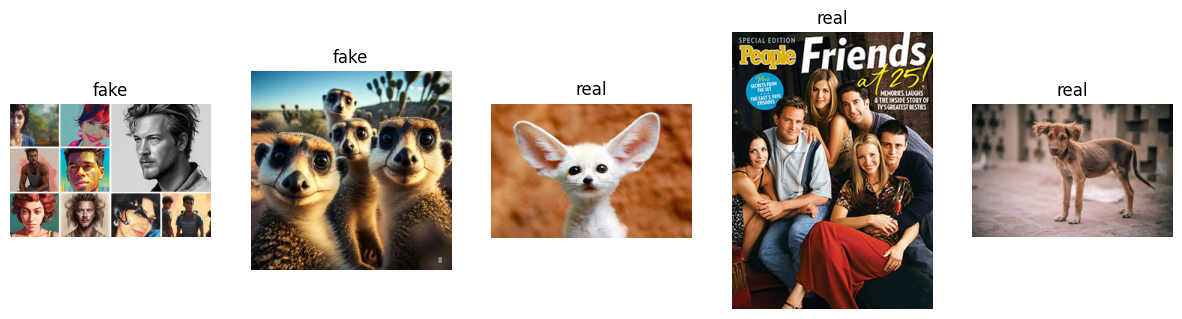

In [7]:
# Function to plot sample images
def plot_images(df, num_samples=5):
    fig, axes = plt.subplots(1, num_samples, figsize=(15, 5))
    sample_df = df.sample(num_samples, random_state=5)
    
    for i, row in enumerate(sample_df.iterrows()):
        img = cv2.imread(row[1]['image_path'])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
        axes[i].imshow(img)
        axes[i].set_title(row[1]['label'])
        axes[i].axis("off")
    
    plt.show()

plot_images(df)

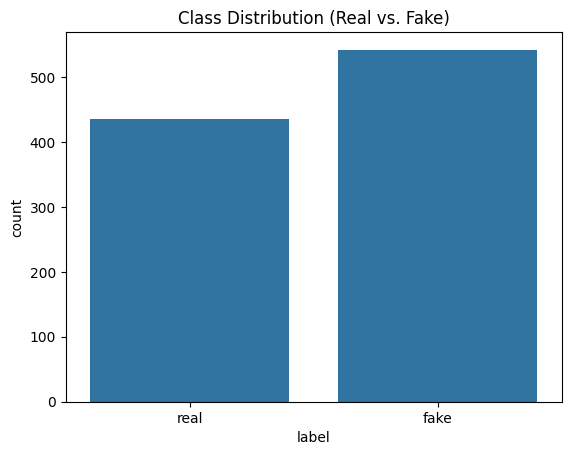

In [8]:
# Checking if data is balanced
sns.countplot(x="label", data=df)
plt.title("Class Distribution (Real vs. Fake)")
plt.show()

In [9]:
# Feature Extraction Using Pretrained CNN
# Load a pre-trained feature extractor (MobileNetV2)
base_model = tf.keras.applications.MobileNetV2(weights="imagenet", include_top=False, pooling="avg")

def extract_features_from_pixels(pixel_array):
    
    img_array = np.array(pixel_array, dtype=np.float32)  # Ensure correct dtype
    img_array = tf.image.resize(img_array, (224, 224))  # Resize to MobileNet input size
    img_array = tf.keras.applications.mobilenet_v2.preprocess_input(img_array)  # Normalize
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

    features = base_model.predict(img_array)
    return features.flatten()

# Apply feature extraction on all images
df["features"] = df["image_vector"].apply(extract_features_from_pixels)

# Convert features into NumPy array
X = np.vstack(df["features"].values)
y = df["label"].map({'real': 0, 'fake': 1}).values  # Convert labels to numeric

# Print shapes
print(f"MobileNetV2 Feature Matrix Shape: {X.shape}")  # (num_samples, num_features)
print(f"Labels Shape: {y.shape}")  # (num_samples,)

/var/folders/8r/nzm4nlwn7d9b7prltmpv_gq80000gn/T/ipykernel_12660/1395286586.py:3: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = tf.keras.applications.MobileNetV2(weights="imagenet", include_top=False, pooling="avg")


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━

In [11]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Machine Learning Models (SVM & Random Forest)

In [12]:
# Train SVM
svm_model = SVC(kernel="linear")
svm_model.fit(X_train, y_train)
svm_preds_mobilenet = svm_model.predict(X_test)
print("SVM Accuracy on MobileNetV2 :", accuracy_score(y_test, svm_preds_mobilenet))
print(classification_report(y_test, svm_preds_mobilenet))

SVM Accuracy on MobileNetV2 : 0.7551020408163265
              precision    recall  f1-score   support

           0       0.78      0.73      0.75       100
           1       0.74      0.78      0.76        96

    accuracy                           0.76       196
   macro avg       0.76      0.76      0.76       196
weighted avg       0.76      0.76      0.76       196



In [13]:
# Train Random Forest
rf_model_mobilenet = RandomForestClassifier(n_estimators=100)
rf_model_mobilenet.fit(X_train, y_train)
rf_preds_mobilenet = rf_model_mobilenet.predict(X_test)
print("Random Forest Accuracy MobileNetV2:", accuracy_score(y_test, rf_preds_mobilenet))
print(classification_report(y_test, rf_preds_mobilenet))

Random Forest Accuracy MobileNetV2: 0.7397959183673469
              precision    recall  f1-score   support

           0       0.86      0.59      0.70       100
           1       0.68      0.90      0.77        96

    accuracy                           0.74       196
   macro avg       0.77      0.74      0.73       196
weighted avg       0.77      0.74      0.73       196



In [14]:
 # Load a pre-trained feature extractor (VGG16)
base_model = tf.keras.applications.VGG16(weights="imagenet", include_top=False, pooling="avg")

def extract_features_from_pixels(pixel_array):
    
    img_array = np.array(pixel_array, dtype=np.float32)  # Ensure correct dtype
    img_array = tf.image.resize(img_array, (224, 224))  # Resize to MobileNet input size
    img_array = tf.keras.applications.mobilenet_v2.preprocess_input(img_array)  # Normalize
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

    features = base_model.predict(img_array)
    return features.flatten()

# Apply feature extraction on all images
df["features"] = df["image_vector"].apply(extract_features_from_pixels)

# Convert features into NumPy array
X = np.vstack(df["features"].values)
y = df["label"].map({'real': 0, 'fake': 1}).values  # Convert labels to numeric

# Print shapes
print(f"Feature Matrix Shape VGG16: {X.shape}")  # (num_samples, num_features)
print(f"Labels Shape: {y.shape}")  # (num_samples,)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 385ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

In [15]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [16]:
# Train SVM
svm_model = SVC(kernel="linear")
svm_model.fit(X_train, y_train)
svm_preds_vgg16 = svm_model.predict(X_test)
print("SVM Accuracy VGG16:", accuracy_score(y_test, svm_preds_vgg16))
print(classification_report(y_test, svm_preds_vgg16))

SVM Accuracy VGG16: 0.8112244897959183
              precision    recall  f1-score   support

           0       0.80      0.84      0.82       100
           1       0.82      0.78      0.80        96

    accuracy                           0.81       196
   macro avg       0.81      0.81      0.81       196
weighted avg       0.81      0.81      0.81       196



In [17]:
# Train Random Forest
rf_model_vgg16 = RandomForestClassifier(n_estimators=100)
rf_model_vgg16.fit(X_train, y_train)
rf_preds_vgg16 = rf_model_vgg16.predict(X_test)
print("Random Forest Accuracy VGG16:", accuracy_score(y_test, rf_preds_vgg16))
print(classification_report(y_test, rf_preds_vgg16))

Random Forest Accuracy VGG16: 0.75
              precision    recall  f1-score   support

           0       0.81      0.67      0.73       100
           1       0.71      0.83      0.77        96

    accuracy                           0.75       196
   macro avg       0.76      0.75      0.75       196
weighted avg       0.76      0.75      0.75       196



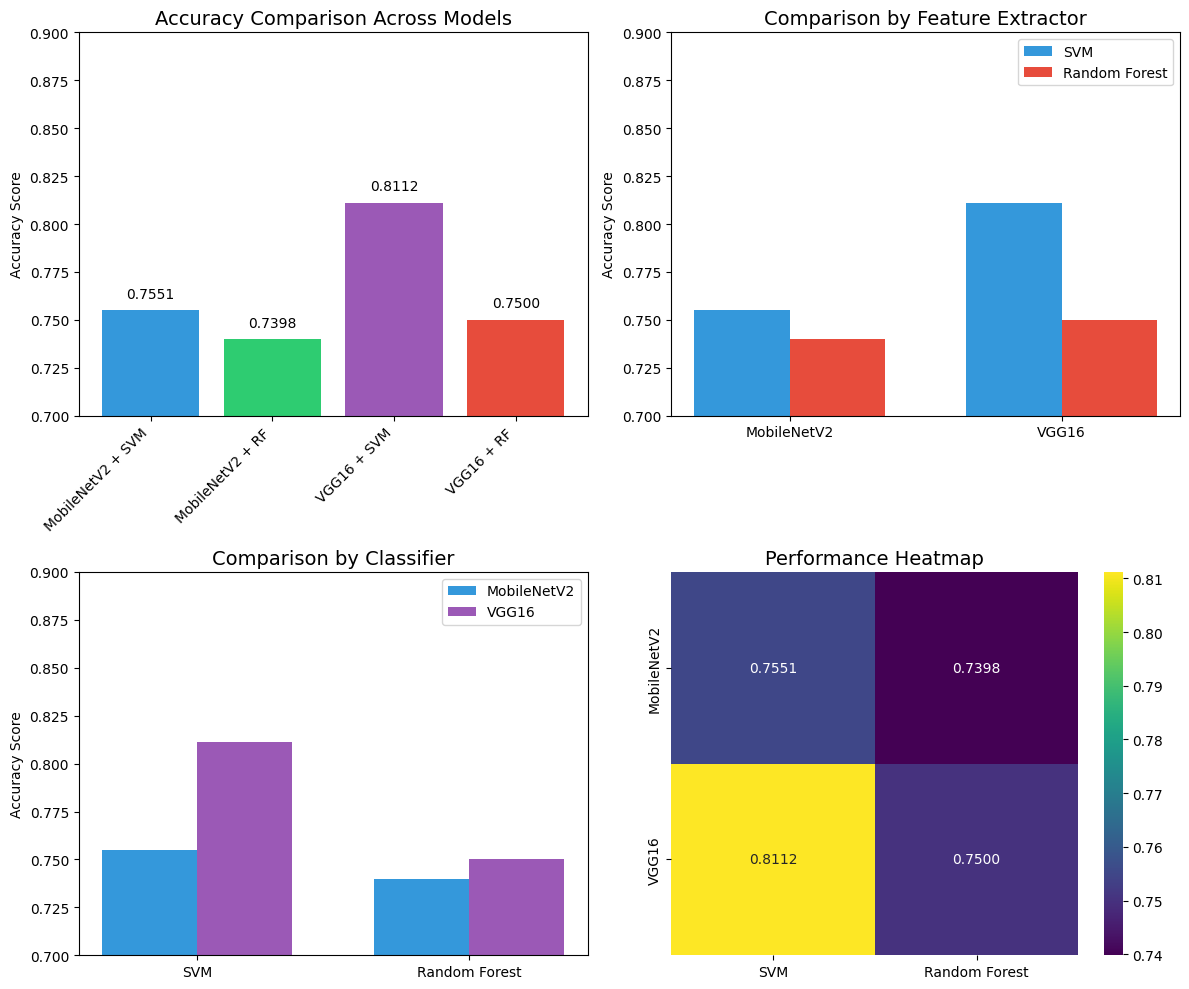

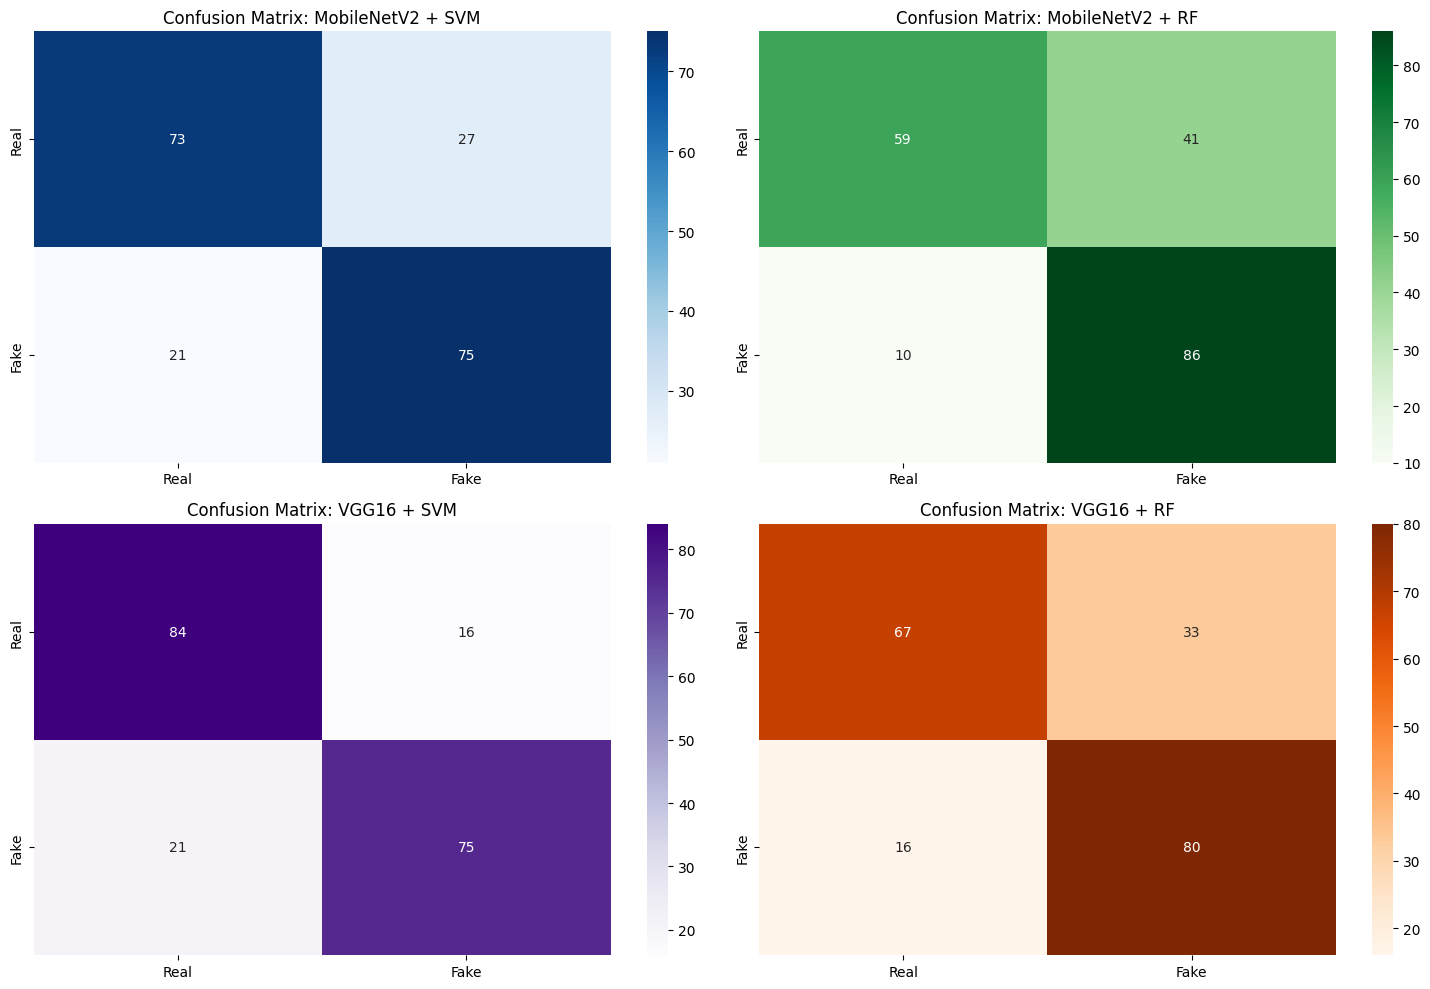

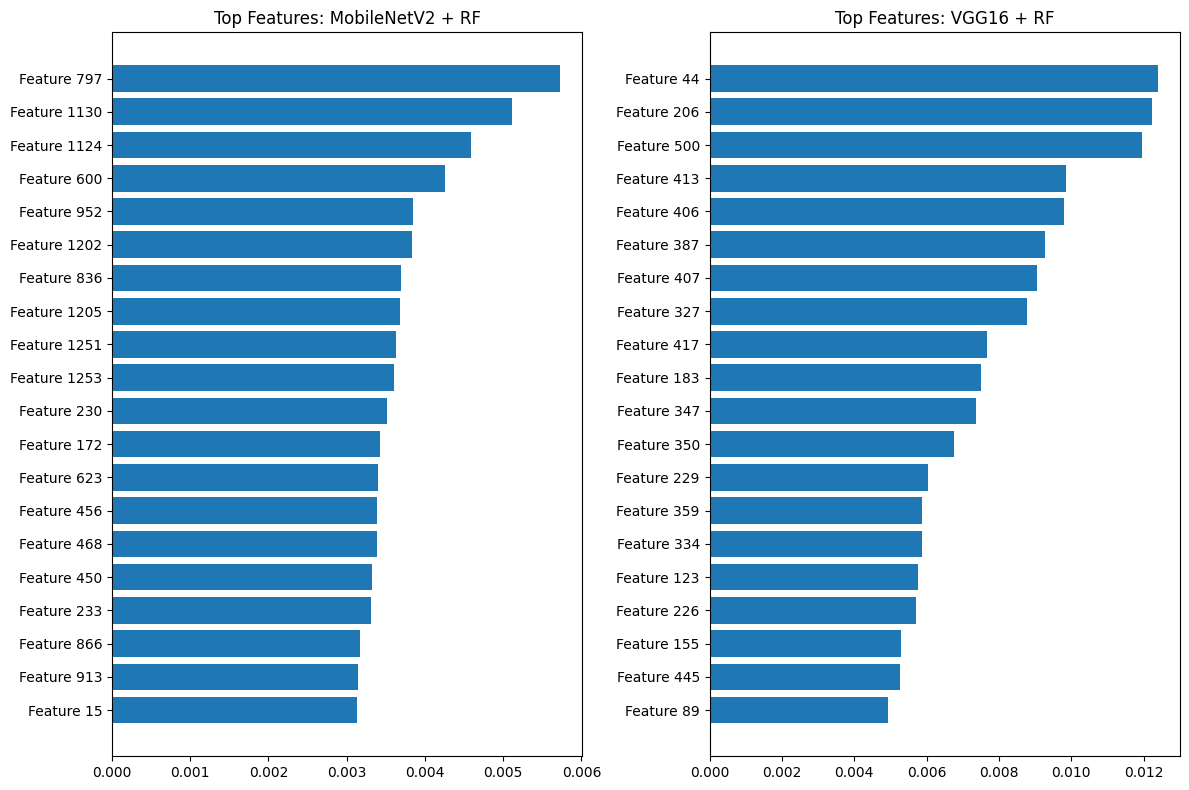

In [18]:
# Store the accuracy results in a dictionary


# Results from your models (replace with actual variable references if needed)
results = {
    'MobileNetV2 + SVM': accuracy_score(y_test, svm_preds_mobilenet),
    'MobileNetV2 + RF': accuracy_score(y_test, rf_preds_mobilenet),
    'VGG16 + SVM': accuracy_score(y_test, svm_preds_vgg16), 
    'VGG16 + RF': accuracy_score(y_test, rf_preds_vgg16)
}



# Create comparison visualizations
plt.figure(figsize=(12, 10))

# 1. Bar chart comparing accuracy scores
plt.subplot(2, 2, 1)
models = list(results.keys())
scores = list(results.values())
colors = ['#3498db', '#2ecc71', '#9b59b6', '#e74c3c']
bars = plt.bar(models, scores, color=colors)
plt.ylim(0.7, 0.9)  # Setting a reasonable y-axis range
plt.title('Accuracy Comparison Across Models', fontsize=14)
plt.ylabel('Accuracy Score')
plt.xticks(rotation=45, ha='right')
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.005,
             f'{height:.4f}', ha='center', va='bottom')

# 2. Grouped bar chart by feature extractor
plt.subplot(2, 2, 2)
feature_extractors = ['MobileNetV2', 'VGG16']
svm_scores = [results['MobileNetV2 + SVM'], results['VGG16 + SVM']]
rf_scores = [results['MobileNetV2 + RF'], results['VGG16 + RF']]

x = np.arange(len(feature_extractors))
width = 0.35

plt.bar(x - width/2, svm_scores, width, label='SVM', color='#3498db')
plt.bar(x + width/2, rf_scores, width, label='Random Forest', color='#e74c3c')
plt.title('Comparison by Feature Extractor', fontsize=14)
plt.xticks(x, feature_extractors)
plt.ylabel('Accuracy Score')
plt.ylim(0.7, 0.9)
plt.legend()

# 3. Grouped bar chart by classifier
plt.subplot(2, 2, 3)
classifiers = ['SVM', 'Random Forest']
mobilenet_scores = [results['MobileNetV2 + SVM'], results['MobileNetV2 + RF']]
vgg16_scores = [results['VGG16 + SVM'], results['VGG16 + RF']]

x = np.arange(len(classifiers))
width = 0.35

plt.bar(x - width/2, mobilenet_scores, width, label='MobileNetV2', color='#3498db')
plt.bar(x + width/2, vgg16_scores, width, label='VGG16', color='#9b59b6')
plt.title('Comparison by Classifier', fontsize=14)
plt.xticks(x, classifiers)
plt.ylabel('Accuracy Score')
plt.ylim(0.7, 0.9)
plt.legend()

# 4. Heatmap representation
plt.subplot(2, 2, 4)
heatmap_data = np.array([
    [results['MobileNetV2 + SVM'], results['MobileNetV2 + RF']],
    [results['VGG16 + SVM'], results['VGG16 + RF']]
])
sns.heatmap(heatmap_data, annot=True, fmt='.4f', cmap='viridis', 
            xticklabels=classifiers, yticklabels=feature_extractors)
plt.title('Performance Heatmap', fontsize=14)

plt.tight_layout()
plt.savefig('model_comparison_results.png', dpi=300, bbox_inches='tight')
plt.show()

# Visualization for confusion matrices
plt.figure(figsize=(15, 10))

# For MobileNetV2 + SVM
plt.subplot(2, 2, 1)
cm1 = confusion_matrix(y_test, svm_preds_mobilenet)
sns.heatmap(cm1, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Real', 'Fake'], yticklabels=['Real', 'Fake'])
plt.title('Confusion Matrix: MobileNetV2 + SVM')

# For MobileNetV2 + RF
plt.subplot(2, 2, 2)
cm2 = confusion_matrix(y_test, rf_preds_mobilenet)
sns.heatmap(cm2, annot=True, fmt='d', cmap='Greens', 
            xticklabels=['Real', 'Fake'], yticklabels=['Real', 'Fake'])
plt.title('Confusion Matrix: MobileNetV2 + RF')

# For VGG16 + SVM
plt.subplot(2, 2, 3)
cm3 = confusion_matrix(y_test, svm_preds_vgg16)
sns.heatmap(cm3, annot=True, fmt='d', cmap='Purples', 
            xticklabels=['Real', 'Fake'], yticklabels=['Real', 'Fake'])
plt.title('Confusion Matrix: VGG16 + SVM')

# For VGG16 + RF
plt.subplot(2, 2, 4)
cm4 = confusion_matrix(y_test, rf_preds_vgg16)
sns.heatmap(cm4, annot=True, fmt='d', cmap='Oranges', 
            xticklabels=['Real', 'Fake'], yticklabels=['Real', 'Fake'])
plt.title('Confusion Matrix: VGG16 + RF')

plt.tight_layout()
plt.savefig('confusion_matrices.png', dpi=300, bbox_inches='tight')
plt.show()

# Feature importance analysis for Random Forest models
if hasattr(rf_model_mobilenet, 'feature_importances_'):
    plt.figure(figsize=(12, 8))
    
    # MobileNetV2 + RF
    importances_mobilenet = rf_model_mobilenet.feature_importances_
    indices_mobilenet = np.argsort(importances_mobilenet)[-20:]  # Top 20 features
    
    plt.subplot(1, 2, 1)
    plt.barh(range(len(indices_mobilenet)), importances_mobilenet[indices_mobilenet])
    plt.yticks(range(len(indices_mobilenet)), [f'Feature {i}' for i in indices_mobilenet])
    plt.title('Top Features: MobileNetV2 + RF')
    
    # VGG16 + RF
    importances_vgg16 = rf_model_vgg16.feature_importances_
    indices_vgg16 = np.argsort(importances_vgg16)[-20:]  # Top 20 features
    
    plt.subplot(1, 2, 2)
    plt.barh(range(len(indices_vgg16)), importances_vgg16[indices_vgg16])
    plt.yticks(range(len(indices_vgg16)), [f'Feature {i}' for i in indices_vgg16])
    plt.title('Top Features: VGG16 + RF')
    
    plt.tight_layout()
    plt.savefig('feature_importance.png', dpi=300, bbox_inches='tight')
    plt.show()

In [39]:
X = df['image_vector']
y = df['label']

In [40]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [41]:
X[0].shape

(1000, 2000, 3)

In [42]:
df.head()

,image_path,label,image_vector
0,dataset/train/real/5360.jpg,real,"[[[219, 200, 160], [205, 186, 146], [210, 190,..."
1,dataset/test/real/5000.jpg,real,"[[[78, 90, 44], [78, 90, 44], [78, 90, 44], [7..."
2,dataset/train/real/5387.jpg,real,"[[[246, 244, 245], [246, 244, 245], [246, 244,..."
3,dataset/test/fake/78.jpg,fake,"[[[23, 91, 126], [23, 91, 126], [24, 92, 127],..."
4,dataset/train/real/5284.jpg,real,"[[[106, 164, 210], [106, 164, 210], [105, 163,..."


In [43]:
def reshape_images(pixel_array):
   
    img_array = np.array(pixel_array, dtype=np.float32)  # Ensure correct dtype
    img_array = tf.image.resize(img_array, (244, 244))  # Resize to MobileNet input size
    return img_array

df['reshaped_images'] = df['image_vector'].apply(reshape_images)

In [44]:
X = np.stack(df['reshaped_images']).astype('float32')
from sklearn.preprocessing import LabelEncoder
y_label = LabelEncoder().fit_transform(df['label'])
X.shape, y_label.shape

((978, 244, 244, 3), (978,))

In [45]:
X_train, X_test, y_train, y_test = train_test_split(X, y_label, test_size=0.2, random_state=42)

 Deep Learning Models (CNN & ViT)

Epoch 1/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 37s 1s/step - accuracy: 0.4679 - loss: 1226.5509 - val_accuracy: 0.5153 - val_loss: 5.1737
Epoch 2/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - accuracy: 0.7294 - loss: 1.1942 - val_accuracy: 0.5765 - val_loss: 1.5583
Epoch 3/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 37s 959ms/step - accuracy: 0.9068 - loss: 0.2598 - val_accuracy: 0.5408 - val_loss: 1.6870
Epoch 4/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 25s 996ms/step - accuracy: 0.9535 - loss: 0.1668 - val_accuracy: 0.5408 - val_loss: 2.7078
Epoch 5/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 24s 972ms/step - accuracy: 0.9744 - loss: 0.0868 - val_accuracy: 0.5714 - val_loss: 2.9571
Epoch 6/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 25s 1s/step - accuracy: 0.9934 - loss: 0.0409 - val_accuracy: 0.5714 - val_loss: 2.5971
Epoch 7/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 25s 988ms/step - accuracy: 0.9937 - loss: 0.0424 - val_accuracy: 0.5765 - val_loss: 2.8335
Epoch 8/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 25s 1s/step - accuracy: 0.9846 - loss: 0.0741 - val_accuracy: 0.6

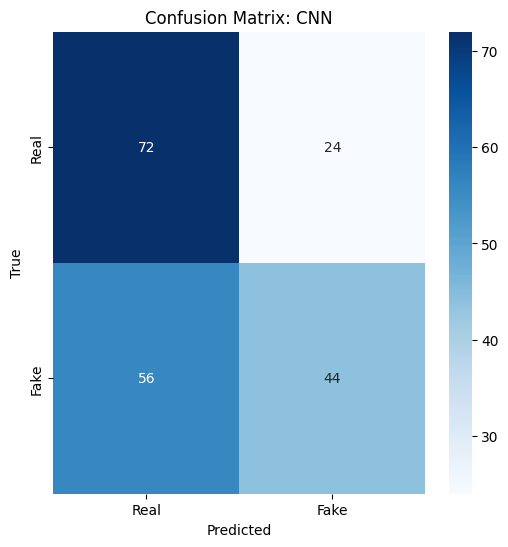

In [46]:
# Define CNN architecture
cnn_model = models.Sequential([
    layers.Input(shape=(244, 244, 3)),
    layers.Conv2D(32, (3,3), activation="relu"),
    layers.MaxPooling2D(2,2),
    layers.Conv2D(64, (3,3), activation="relu"),
    layers.MaxPooling2D(2,2),
    layers.Flatten(),
    layers.Dense(128, activation="relu"),
    layers.Dense(1, activation="sigmoid")  # Binary classification
])

# Compile and train
cnn_model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
history_cnn = cnn_model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))

# Evaluate the model
cnn_loss, cnn_accuracy = cnn_model.evaluate(X_test, y_test)
print(f"CNN Accuracy: {cnn_accuracy:.4f}")

# Make predictions
cnn_preds = (cnn_model.predict(X_test) > 0.5).astype("int32")

# Print classification report
from sklearn.metrics import classification_report, confusion_matrix
print("Classification Report - CNN")
print(classification_report(y_test, cnn_preds))

# Generate confusion matrix
plt.figure(figsize=(6, 6))
cm = confusion_matrix(y_test, cnn_preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Real', 'Fake'], yticklabels=['Real', 'Fake'])
plt.title('Confusion Matrix: CNN')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.savefig('cnn_confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

In [47]:
# First, extract the arrays from the pandas Series
X_train_arrays = [np.array(x) for x in X_train]
X_test_arrays = [np.array(x) for x in X_test]

# Check if the arrays have different shapes
train_shapes = set(arr.shape for arr in X_train_arrays)
print("Unique shapes in X_train:", train_shapes)

# Resize all arrays to the target size (244, 244, 3)
import cv2  # If not installed, use: !pip install opencv-python

def resize_image(img, target_size=(244, 244)):
    # Ensure the image is in the right format for resize
    if len(img.shape) == 3:  # Color image
        return cv2.resize(img, target_size)
    else:  # Grayscale or other
        # Resize and then convert to 3 channels if needed
        resized = cv2.resize(img, target_size)
        if len(resized.shape) == 2:
            return np.stack([resized] * 3, axis=-1)
        return resized

# Resize all arrays to the same shape
X_train_resized = np.array([resize_image(img) for img in X_train_arrays])
X_test_resized = np.array([resize_image(img) for img in X_test_arrays])

print("Resized X_train shape:", X_train_resized.shape)
print("Resized X_test shape:", X_test_resized.shape)

# Convert to float32
X_train_resized = X_train_resized.astype(np.float32) / 255.0  # Normalize to [0,1]
X_test_resized = X_test_resized.astype(np.float32) / 255.0

# Update the original variables
X_train = X_train_resized
X_test = X_test_resized

Unique shapes in X_train: {(244, 244, 3)}
Resized X_train shape: (782, 244, 244, 3)
Resized X_test shape: (196, 244, 244, 3)


ViT

In [48]:
def create_simple_vit_classifier():
    import tensorflow as tf
    from tensorflow.keras import layers, regularizers
    
    # Input layer
    input_shape = (244, 244, 3)
    inputs = layers.Input(shape=input_shape)
    
    # Parameters
    patch_size = 16
    projection_dim = 128
    num_patches = (input_shape[0] // patch_size) * (input_shape[1] // patch_size)
    num_heads = 8
    transformer_layers = 6
    
    # Create patches
    x = layers.Conv2D(
        filters=projection_dim,
        kernel_size=patch_size,
        strides=patch_size,
        padding="valid"
    )(inputs)
    
    # Reshape to sequence
    patch_dim = x.shape[-3] * x.shape[-2]
    x = layers.Reshape((patch_dim, projection_dim))(x)
    
    # Position embeddings (fixed implementation)
    positions = tf.range(start=0, limit=patch_dim, delta=1)
    pos_embedding = layers.Embedding(
        input_dim=patch_dim, output_dim=projection_dim
    )(positions)
    
    # Add position embeddings (correctly)
    x = x + tf.expand_dims(pos_embedding, axis=0)
    
    # Transformer blocks
    for _ in range(transformer_layers):
        # Layer norm 1
        ln1 = layers.LayerNormalization(epsilon=1e-6)(x)
        
        # Self-attention
        attn = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim // num_heads, dropout=0.1
        )(ln1, ln1)
        
        # Residual 1
        x1 = layers.Add()([attn, x])
        
        # Layer norm 2
        ln2 = layers.LayerNormalization(epsilon=1e-6)(x1)
        
        # MLP
        mlp = layers.Dense(projection_dim * 4, activation='gelu')(ln2)
        mlp = layers.Dropout(0.2)(mlp)
        mlp = layers.Dense(projection_dim)(mlp)
        mlp = layers.Dropout(0.2)(mlp)
        
        # Residual 2
        x = layers.Add()([mlp, x1])
    
    # Classification head
    x = layers.LayerNormalization(epsilon=1e-6)(x)
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dropout(0.2)(x)
    x = layers.Dense(1024, activation='gelu')(x)
    x = layers.Dropout(0.2)(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)
    
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model

# Create and compile the model
simple_vit_model = create_simple_vit_classifier()

# Compile with a simpler approach
simple_vit_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Train with callbacks for better results
callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=2)
]

# Train the model
history_simple_vit = simple_vit_model.fit(
    X_train, y_train,
    batch_size=16,
    epochs=40,
    validation_data=(X_test, y_test),
    callbacks=callbacks
)

# Evaluate
simple_vit_loss, simple_vit_accuracy = simple_vit_model.evaluate(X_test, y_test)
print(f"ViT Model Accuracy: {simple_vit_accuracy:.4f}")

# Add to results
results = results if 'results' in locals() else {}
results['Simple ViT'] = simple_vit_accuracy

Epoch 1/40
49/49 ━━━━━━━━━━━━━━━━━━━━ 100s 2s/step - accuracy: 0.4781 - loss: 0.7113 - val_accuracy: 0.4898 - val_loss: 0.9091 - learning_rate: 1.0000e-04
Epoch 2/40
49/49 ━━━━━━━━━━━━━━━━━━━━ 74s 2s/step - accuracy: 0.6095 - loss: 0.6931 - val_accuracy: 0.7143 - val_loss: 0.6414 - learning_rate: 1.0000e-04
Epoch 3/40
49/49 ━━━━━━━━━━━━━━━━━━━━ 74s 2s/step - accuracy: 0.5980 - loss: 0.6754 - val_accuracy: 0.6173 - val_loss: 0.6381 - learning_rate: 1.0000e-04
Epoch 4/40
49/49 ━━━━━━━━━━━━━━━━━━━━ 77s 2s/step - accuracy: 0.5985 - loss: 0.6661 - val_accuracy: 0.5867 - val_loss: 0.6656 - learning_rate: 1.0000e-04
Epoch 5/40
49/49 ━━━━━━━━━━━━━━━━━━━━ 81s 2s/step - accuracy: 0.6294 - loss: 0.6739 - val_accuracy: 0.5204 - val_loss: 0.7313 - learning_rate: 1.0000e-04
Epoch 6/40
49/49 ━━━━━━━━━━━━━━━━━━━━ 77s 2s/step - accuracy: 0.5941 - loss: 0.6826 - val_accuracy: 0.5816 - val_loss: 0.6738 - learning_rate: 5.0000e-05
Epoch 7/40
49/49 ━━━━━━━━━━━━━━━━━━━━ 74s 2s/step - accuracy: 0.6526 - loss

In [49]:
# First, check if results dictionary exists, if not create it
if 'results' not in locals() and 'results' not in globals():
    results = {}

# Make sure you've added the CNN accuracy to the results dictionary
# You should add this after evaluating your CNN model
cnn_loss, cnn_accuracy = cnn_model.evaluate(X_test, y_test)
results['CNN'] = cnn_accuracy

# And similarly for ViT
vit_loss, vit_accuracy = simple_vit_model.evaluate(X_test, y_test)
results['ViT'] = vit_accuracy



7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 251ms/step - accuracy: 0.6640 - loss: 0.6828
7/7 ━━━━━━━━━━━━━━━━━━━━ 7s 941ms/step - accuracy: 0.6480 - loss: 0.6134


7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 261ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 8s 953ms/step


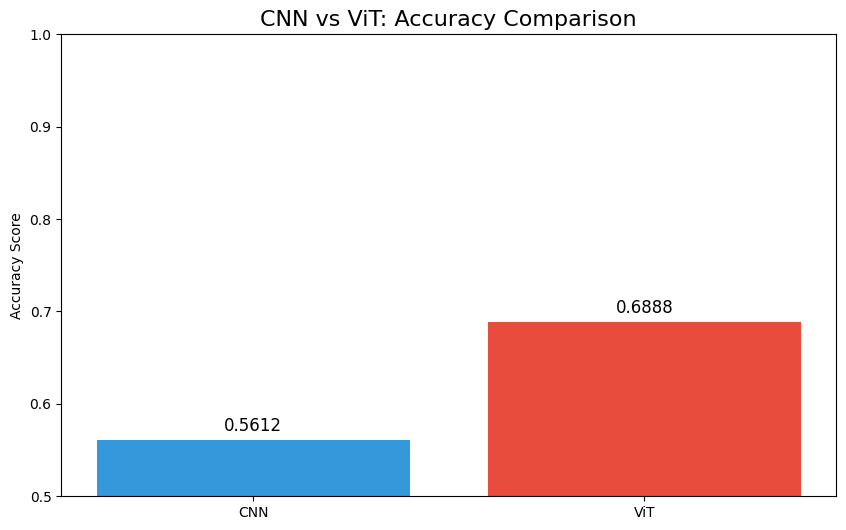

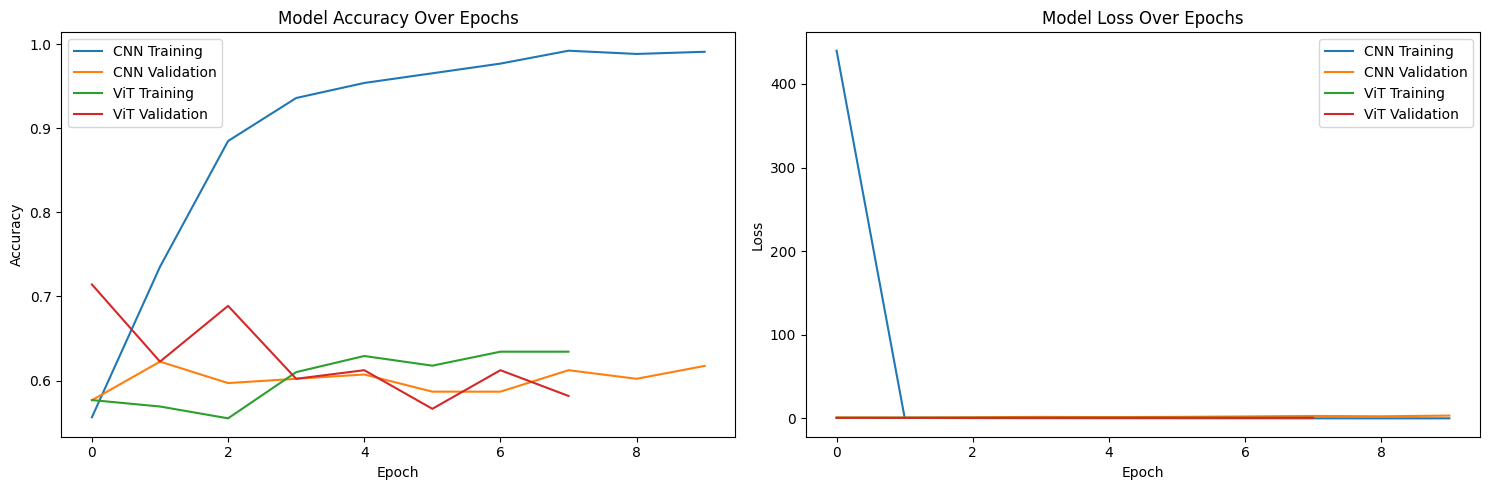

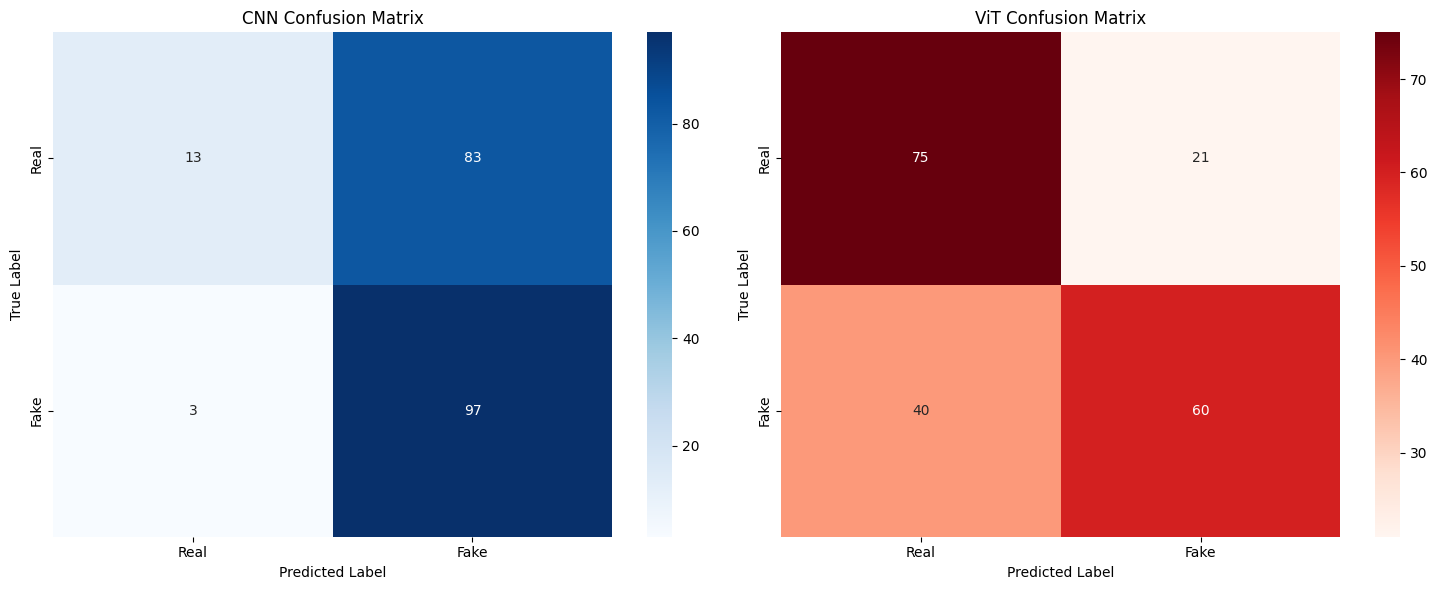

7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 216ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 829ms/step


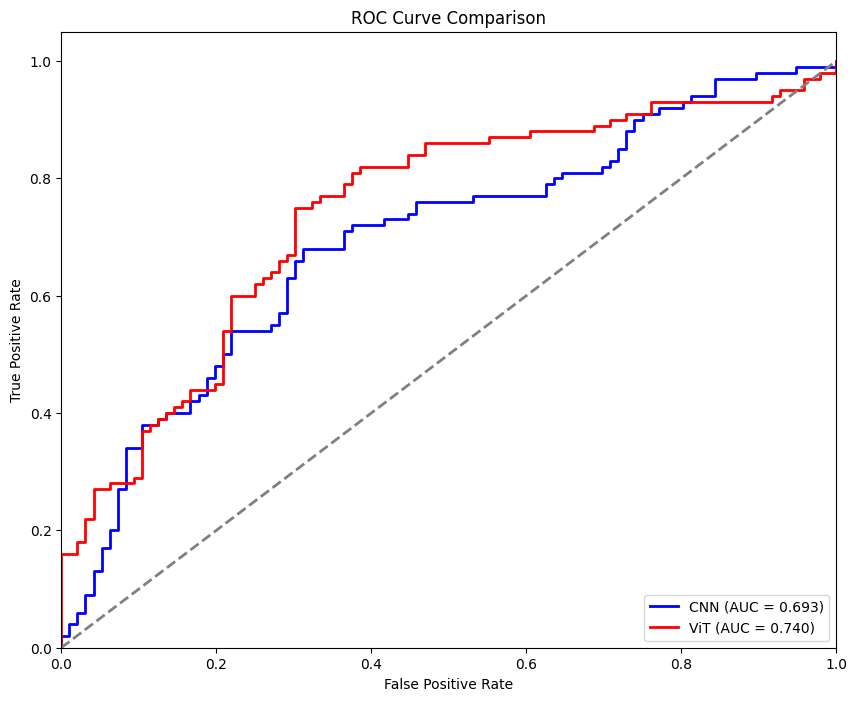

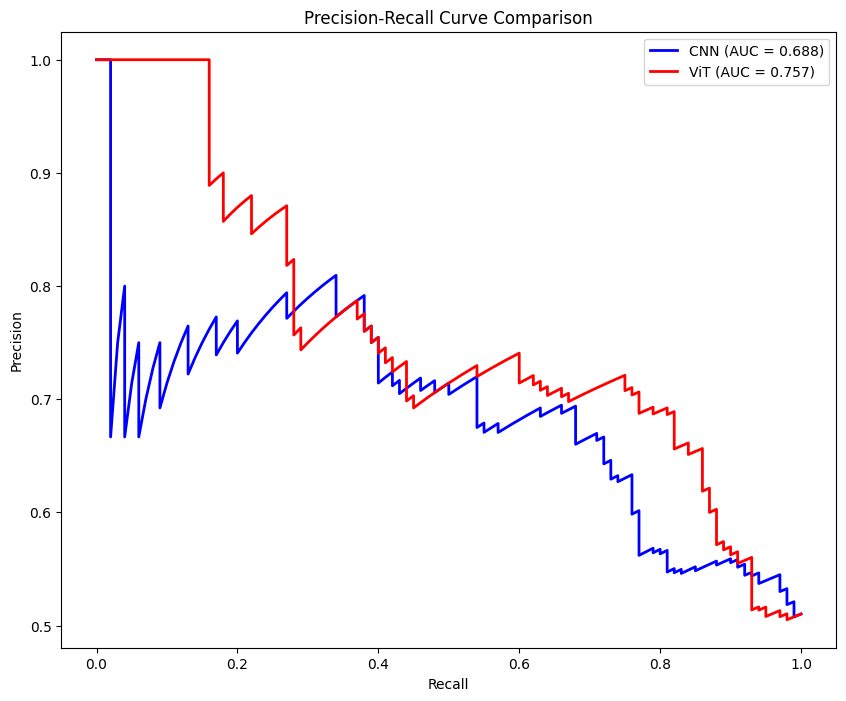

CNN Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.14      0.23        96
           1       0.54      0.97      0.69       100

    accuracy                           0.56       196
   macro avg       0.68      0.55      0.46       196
weighted avg       0.67      0.56      0.47       196


ViT Classification Report:
              precision    recall  f1-score   support

           0       0.65      0.78      0.71        96
           1       0.74      0.60      0.66       100

    accuracy                           0.69       196
   macro avg       0.70      0.69      0.69       196
weighted avg       0.70      0.69      0.69       196

+-----------+--------+--------+
|   Metric  |  CNN   |  ViT   |
+-----------+--------+--------+
|  Accuracy | 0.5612 | 0.6888 |
| Precision | 0.5389 | 0.7407 |
|   Recall  | 0.9700 | 0.6000 |
|  F1 Score | 0.6929 | 0.6630 |
|  ROC AUC  | 0.6930 | 0.7404 |
|   PR AUC  | 0.6876 | 0.7575 |
+--

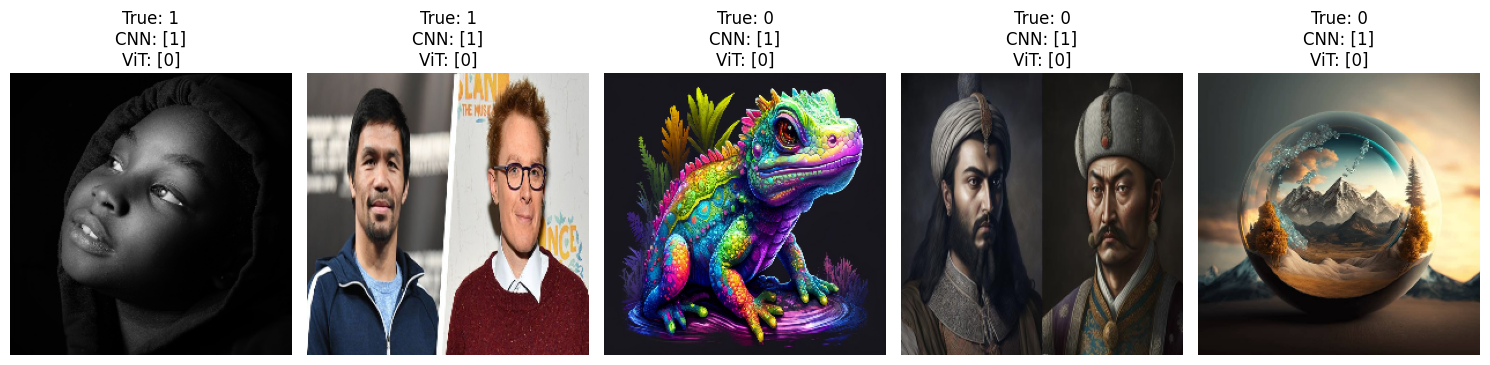

In [32]:


# If you need to generate predictions first:
cnn_preds = (cnn_model.predict(X_test) > 0.5).astype("int32")
vit_preds = (simple_vit_model.predict(X_test) > 0.5).astype("int32")

# 1. Overall Accuracy Comparison
plt.figure(figsize=(10, 6))
models = ['CNN', 'ViT']
accuracies = [results['CNN'], results['ViT']]
colors = ['#3498db', '#e74c3c']

plt.bar(models, accuracies, color=colors)
plt.title('CNN vs ViT: Accuracy Comparison', fontsize=16)
plt.ylabel('Accuracy Score')
plt.ylim(0.5, 1.0)  # Adjust as needed
for i, v in enumerate(accuracies):
    plt.text(i, v + 0.01, f"{v:.4f}", ha='center', fontsize=12)
plt.savefig('cnn_vs_vit_accuracy.png', dpi=300, bbox_inches='tight')
plt.show()

# 2. Training History Comparison
plt.figure(figsize=(15, 5))

# Training Accuracy
plt.subplot(1, 2, 1)
plt.plot(history_cnn.history['accuracy'], label='CNN Training')
plt.plot(history_cnn.history['val_accuracy'], label='CNN Validation')
plt.plot(history_simple_vit.history['accuracy'], label='ViT Training')
plt.plot(history_simple_vit.history['val_accuracy'], label='ViT Validation')
plt.title('Model Accuracy Over Epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

# Training Loss
plt.subplot(1, 2, 2)
plt.plot(history_cnn.history['loss'], label='CNN Training')
plt.plot(history_cnn.history['val_loss'], label='CNN Validation')
plt.plot(history_simple_vit.history['loss'], label='ViT Training')
plt.plot(history_simple_vit.history['val_loss'], label='ViT Validation')
plt.title('Model Loss Over Epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

plt.tight_layout()
plt.savefig('cnn_vs_vit_training_history.png', dpi=300, bbox_inches='tight')
plt.show()

# 3. Confusion Matrices
plt.figure(figsize=(15, 6))

# CNN Confusion Matrix
plt.subplot(1, 2, 1)
cm_cnn = confusion_matrix(y_test, cnn_preds)
sns.heatmap(cm_cnn, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Real', 'Fake'], yticklabels=['Real', 'Fake'])
plt.title('CNN Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# ViT Confusion Matrix
plt.subplot(1, 2, 2)
cm_vit = confusion_matrix(y_test, vit_preds)
sns.heatmap(cm_vit, annot=True, fmt='d', cmap='Reds', 
            xticklabels=['Real', 'Fake'], yticklabels=['Real', 'Fake'])
plt.title('ViT Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

plt.tight_layout()
plt.savefig('cnn_vs_vit_confusion_matrices.png', dpi=300, bbox_inches='tight')
plt.show()

# 4. ROC Curves
plt.figure(figsize=(10, 8))

# Get probability predictions
cnn_prob = cnn_model.predict(X_test)
vit_prob = simple_vit_model.predict(X_test)

# Calculate ROC curve points
fpr_cnn, tpr_cnn, _ = roc_curve(y_test, cnn_prob)
fpr_vit, tpr_vit, _ = roc_curve(y_test, vit_prob)

# Calculate AUC
roc_auc_cnn = auc(fpr_cnn, tpr_cnn)
roc_auc_vit = auc(fpr_vit, tpr_vit)

# Plot ROC curves
plt.plot(fpr_cnn, tpr_cnn, color='blue', lw=2, 
         label=f'CNN (AUC = {roc_auc_cnn:.3f})')
plt.plot(fpr_vit, tpr_vit, color='red', lw=2, 
         label=f'ViT (AUC = {roc_auc_vit:.3f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend(loc="lower right")
plt.savefig('cnn_vs_vit_roc_curves.png', dpi=300, bbox_inches='tight')
plt.show()

# 5. Precision-Recall Curves
plt.figure(figsize=(10, 8))

# Calculate precision-recall curve points
precision_cnn, recall_cnn, _ = precision_recall_curve(y_test, cnn_prob)
precision_vit, recall_vit, _ = precision_recall_curve(y_test, vit_prob)

# Calculate AUC
pr_auc_cnn = auc(recall_cnn, precision_cnn)
pr_auc_vit = auc(recall_vit, precision_vit)

# Plot precision-recall curves
plt.plot(recall_cnn, precision_cnn, color='blue', lw=2,
         label=f'CNN (AUC = {pr_auc_cnn:.3f})')
plt.plot(recall_vit, precision_vit, color='red', lw=2,
         label=f'ViT (AUC = {pr_auc_vit:.3f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve Comparison')
plt.legend(loc="best")
plt.savefig('cnn_vs_vit_precision_recall_curves.png', dpi=300, bbox_inches='tight')
plt.show()

# 6. Classification Reports
print("CNN Classification Report:")
print(classification_report(y_test, cnn_preds))

print("\nViT Classification Report:")
print(classification_report(y_test, vit_preds))

# 7. Model Performance Comparison Table
from prettytable import PrettyTable
table = PrettyTable()
table.field_names = ["Metric", "CNN", "ViT"]

# Get metrics from classification reports
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

metrics = {
    "Accuracy": [accuracy_score(y_test, cnn_preds), accuracy_score(y_test, vit_preds)],
    "Precision": [precision_score(y_test, cnn_preds), precision_score(y_test, vit_preds)],
    "Recall": [recall_score(y_test, cnn_preds), recall_score(y_test, vit_preds)],
    "F1 Score": [f1_score(y_test, cnn_preds), f1_score(y_test, vit_preds)],
    "ROC AUC": [roc_auc_cnn, roc_auc_vit],
    "PR AUC": [pr_auc_cnn, pr_auc_vit]
}

for metric, values in metrics.items():
    table.add_row([metric, f"{values[0]:.4f}", f"{values[1]:.4f}"])

print(table)

# 8. Save the metrics to CSV for reporting
import pandas as pd
df_metrics = pd.DataFrame(metrics, index=["CNN", "ViT"]).transpose()
df_metrics.to_csv('cnn_vs_vit_metrics.csv')

# 9. Plot misclassified examples (optional)
def plot_misclassifications():
    # Find indices where models disagree
    disagreement = np.where(cnn_preds != vit_preds)[0]
    
    if len(disagreement) > 0:
        plt.figure(figsize=(15, 5))
        for i, idx in enumerate(disagreement[:5]):  # Show first 5 disagreements
            plt.subplot(1, 5, i+1)
            plt.imshow(X_test[idx])
            plt.title(f"True: {y_test[idx]}\nCNN: {cnn_preds[idx]}\nViT: {vit_preds[idx]}")
            plt.axis('off')
        plt.tight_layout()
        plt.savefig('model_disagreements.png', dpi=300, bbox_inches='tight')
        plt.show()

plot_misclassifications()